In [1]:
from PIL import Image, ImageFont
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image, to_tensor
from IPython.display import display

import clip
from clip.model import CLIP
from utils.transform_image import draw_text_with_new_lines, char_size
from utils.initialize_font_data import fox_text, fox_text_four_lines, exclusive_attributes
from utils.init_model import model, preprocess, load_model, device, my_preprocess, preprocess_for_aug, preprocess_for_normalize
from utils.clip_vae import VAE, VAELoss, CNNDecoder
from utils.dataset import MyDataset, set_image_tensors

exclusive_attributes:  []
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, upsample_to_128=False):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()
        self.upsample_to_128 = upsample_to_128
        if self.upsample_to_128:
            self.upsample = nn.Upsample(size=(128, 128), mode='nearest')

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        x =  self.act_fnc(self.bn2(x + skip))
        if self.upsample_to_128:
            x = self.upsample(x)
        return x

In [3]:
class CNNEncoder(nn.Module):
    """
    Encoder block
    Built for a 3x64x64 image and will result in a latent vector of size z x 1 x 1
    As the network is fully convolutional it will work for images LARGER than 64
    For images sized 64 * n where n is a power of 2, (1, 2, 4, 8 etc) the latent feature map size will be z x n x n

    When in .eval() the Encoder will not sample from the distribution and will instead output mu as the encoding vector
    and log_var will be None
    """
    def __init__(self, clip_model: CLIP, input_ch=1, ch=64, latent_dim=512):
        super(CNNEncoder, self).__init__()
        self.conv_in = nn.Conv2d(input_ch, ch // 4, 7, 1, 3)
        self.res_down_block1 = ResDown(ch // 4, ch // 2, upsample_to_128=True)
        self.res_down_block2 = ResDown(ch // 2, ch)
        self.res_down_block3 = ResDown(ch, 2 * ch)
        self.res_down_block4 = ResDown(2 * ch, 4 * ch)
        self.res_down_block5 = ResDown(4 * ch, 8 * ch)
        self.res_down_block6 = ResDown(8 * ch, 16 * ch)
        self.conv_mu = nn.Conv2d(16 * ch, latent_dim, 4, 1)
        self.conv_log_var = nn.Conv2d(16 * ch, latent_dim, 4, 1)
        self.act_fnc = nn.ELU()

        self.dtype = clip_model.dtype
        self.to(self.dtype)

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 128
        x = self.res_down_block2(x)  # 64
        x = self.res_down_block3(x)  # 32
        x = self.res_down_block4(x)  # 16
        x = self.res_down_block5(x)  # 8
        x = self.res_down_block6(x)  # 4
        mu = self.conv_mu(x)  # 1
        log_var = self.conv_log_var(x)  # 1

        if self.training:
            x = self.sample(mu, log_var)
        else:
            x = mu

        return x, mu, log_var

class CNNVAE(nn.Module):
    def __init__(
        self,
        clip_model: CLIP,
        latent_dim: int = 512,
        input_ch: int = 1,
        output_ch: int = 1,
    ) -> None:
        super(CNNVAE, self).__init__()
        self.dtype = clip_model.dtype
        self.input_ch = 1
        self.output_ch = output_ch
        self.input_res = clip_model.visual.input_resolution
        self.output_res = clip_model.visual.input_resolution
        self.output_dim = self.output_res * self.output_res * self.output_ch
        self.latent_dim = latent_dim

        self.decoder = CNNDecoder(clip_model, output_ch, latent_dim=latent_dim)
        self.encoder = CNNEncoder(clip_model, input_ch=input_ch, latent_dim=latent_dim)

        # to detype
        self.to(self.dtype)

    def forward(self, x):
        z, mean, logvar = self.encoder(x)
        x = self.decoder(z)
        # x = x.view(-1, self.output_ch, self.output_res, self.output_res)
        return x, mean, logvar

In [4]:
font_dir = '../gwfonts'
json_path = '../attributeData/train_font_to_attribute_values_5.json'
dataset = MyDataset(
    font_dir=font_dir,
    json_path=json_path,
    texts_for_font_image=[fox_text],
    use_negative=True,
    use_weight=False,
    use_score=False,
    use_multiple_attributes=True,
    use_random_attributes=True,
    random_prompts_num=50,
    max_sample_num=3,
    rich_prompt=False,
    sample_num_each_epoch=1,
    image_file_dir=None,
    attribute_threshold=50,
    attribute_under_threshold=50,
    preprocess=my_preprocess,
    dump_image=True,
    exclusive_attributes=exclusive_attributes,
    geta=1.0,
    single_character=False,
    use_negative_loss=False,
    store_unnormalized_image=True,
    use_clip_like_format=False,
    char_size=300,
)
set_image_tensors(
    dataset, preprocess=my_preprocess, sample_num=5
)

100%|██████████| 120/120 [00:00<00:00, 203.33it/s]


create image tensors from font files ...


100%|██████████| 120/120 [00:05<00:00, 21.64it/s]


In [56]:
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
vae = CNNVAE(model).to(device)
vae_loss = VAELoss()

In [57]:
epoch = 10000
lr = 1e-5
vae_optimizer = optim.Adam(
    vae.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
vae_schedular = optim.lr_scheduler.LinearLR(
    vae_optimizer,
    start_factor=1,
    end_factor=0.1,
    total_iters=epoch * len(data_loader),
)

In [58]:
for i in tqdm(range(epoch)):
  it = iter(data_loader)
  total_loss = 0
  for images, unnormalized_images, texts in it:
    vae_optimizer.zero_grad()
    x = unnormalized_images.to(device)
    recon_x, mean, logvar = vae(x)
    reshaped_x = x.view(-1, 1 * 224 * 224)
    loss = vae_loss(recon_x, reshaped_x, mean, logvar)
    loss.backward()
    vae_optimizer.step()
    vae_schedular.step()
    total_loss += loss.item()
  if i % 100 == 0:
    print(f'epoch: {i}, loss: {total_loss}')

  0%|          | 1/10000 [00:00<53:24,  3.12it/s]

epoch: 0, loss: 9752.0


  1%|          | 101/10000 [00:30<50:38,  3.26it/s]

epoch: 100, loss: 149.875


  2%|▏         | 201/10000 [01:01<50:07,  3.26it/s]

epoch: 200, loss: 31.25


  3%|▎         | 301/10000 [01:32<49:35,  3.26it/s]

epoch: 300, loss: 9.90625


  4%|▍         | 401/10000 [02:02<49:02,  3.26it/s]

epoch: 400, loss: 4.4140625


  5%|▌         | 501/10000 [02:33<48:35,  3.26it/s]

epoch: 500, loss: 4.173828125


  6%|▌         | 601/10000 [03:04<47:58,  3.27it/s]

epoch: 600, loss: 4.2109375


  7%|▋         | 701/10000 [03:34<47:31,  3.26it/s]

epoch: 700, loss: 3.4482421875


  8%|▊         | 801/10000 [04:05<46:58,  3.26it/s]

epoch: 800, loss: 3.181640625


  9%|▉         | 901/10000 [04:36<46:28,  3.26it/s]

epoch: 900, loss: 3.3896484375


 10%|█         | 1001/10000 [05:06<45:59,  3.26it/s]

epoch: 1000, loss: 2.7724609375


 11%|█         | 1101/10000 [05:37<45:31,  3.26it/s]

epoch: 1100, loss: 2.919921875


 12%|█▏        | 1201/10000 [06:08<44:55,  3.26it/s]

epoch: 1200, loss: 2.7255859375


 13%|█▎        | 1301/10000 [06:38<44:31,  3.26it/s]

epoch: 1300, loss: 2.3125


 14%|█▍        | 1401/10000 [07:09<43:55,  3.26it/s]

epoch: 1400, loss: 2.5078125


 15%|█▌        | 1501/10000 [07:40<43:21,  3.27it/s]

epoch: 1500, loss: 2.1865234375


 16%|█▌        | 1601/10000 [08:10<42:52,  3.26it/s]

epoch: 1600, loss: 2.2587890625


 17%|█▋        | 1701/10000 [08:41<42:21,  3.27it/s]

epoch: 1700, loss: 2.234375


 18%|█▊        | 1801/10000 [09:12<41:54,  3.26it/s]

epoch: 1800, loss: 2.4228515625


 19%|█▉        | 1901/10000 [09:42<41:24,  3.26it/s]

epoch: 1900, loss: 2.318359375


 20%|██        | 2001/10000 [10:13<40:52,  3.26it/s]

epoch: 2000, loss: 2.0908203125


 21%|██        | 2101/10000 [10:43<40:19,  3.26it/s]

epoch: 2100, loss: 2.3779296875


 22%|██▏       | 2201/10000 [11:14<39:50,  3.26it/s]

epoch: 2200, loss: 2.2412109375


 23%|██▎       | 2301/10000 [11:45<39:21,  3.26it/s]

epoch: 2300, loss: 1.9814453125


 24%|██▍       | 2401/10000 [12:15<38:51,  3.26it/s]

epoch: 2400, loss: 2.1494140625


 25%|██▌       | 2501/10000 [12:46<38:13,  3.27it/s]

epoch: 2500, loss: 1.833984375


 26%|██▌       | 2601/10000 [13:17<37:46,  3.26it/s]

epoch: 2600, loss: 1.927734375


 27%|██▋       | 2701/10000 [13:47<37:19,  3.26it/s]

epoch: 2700, loss: 1.7958984375


 28%|██▊       | 2801/10000 [14:18<36:46,  3.26it/s]

epoch: 2800, loss: 1.5966796875


 29%|██▉       | 2901/10000 [14:49<36:20,  3.26it/s]

epoch: 2900, loss: 1.7958984375


 30%|███       | 3001/10000 [15:19<35:42,  3.27it/s]

epoch: 3000, loss: 1.80615234375


 31%|███       | 3101/10000 [15:50<35:15,  3.26it/s]

epoch: 3100, loss: 1.9150390625


 32%|███▏      | 3201/10000 [16:21<34:44,  3.26it/s]

epoch: 3200, loss: 1.80029296875


 33%|███▎      | 3301/10000 [16:51<34:16,  3.26it/s]

epoch: 3300, loss: 1.60107421875


 34%|███▍      | 3401/10000 [17:22<33:41,  3.26it/s]

epoch: 3400, loss: 1.73291015625


 35%|███▌      | 3501/10000 [17:53<33:15,  3.26it/s]

epoch: 3500, loss: 1.947265625


 36%|███▌      | 3601/10000 [18:23<32:43,  3.26it/s]

epoch: 3600, loss: 1.783203125


 37%|███▋      | 3701/10000 [18:54<32:11,  3.26it/s]

epoch: 3700, loss: 1.44970703125


 38%|███▊      | 3801/10000 [19:25<31:39,  3.26it/s]

epoch: 3800, loss: 1.60546875


 39%|███▉      | 3901/10000 [19:55<31:07,  3.27it/s]

epoch: 3900, loss: 1.5517578125


 40%|████      | 4001/10000 [20:26<30:37,  3.26it/s]

epoch: 4000, loss: 1.720703125


 41%|████      | 4101/10000 [20:56<30:05,  3.27it/s]

epoch: 4100, loss: 1.50390625


 42%|████▏     | 4201/10000 [21:27<29:35,  3.27it/s]

epoch: 4200, loss: 1.58544921875


 43%|████▎     | 4301/10000 [21:58<29:08,  3.26it/s]

epoch: 4300, loss: 1.693359375


 44%|████▍     | 4401/10000 [22:28<28:38,  3.26it/s]

epoch: 4400, loss: 1.51904296875


 45%|████▌     | 4501/10000 [22:59<28:05,  3.26it/s]

epoch: 4500, loss: 1.68017578125


 46%|████▌     | 4601/10000 [23:30<27:35,  3.26it/s]

epoch: 4600, loss: 1.4423828125


 47%|████▋     | 4701/10000 [24:00<27:01,  3.27it/s]

epoch: 4700, loss: 1.498046875


 48%|████▊     | 4801/10000 [24:31<26:30,  3.27it/s]

epoch: 4800, loss: 1.42822265625


 49%|████▉     | 4901/10000 [25:02<26:02,  3.26it/s]

epoch: 4900, loss: 1.52880859375


 50%|█████     | 5001/10000 [25:32<25:33,  3.26it/s]

epoch: 5000, loss: 1.5224609375


 51%|█████     | 5101/10000 [26:03<25:00,  3.26it/s]

epoch: 5100, loss: 1.3974609375


 52%|█████▏    | 5201/10000 [26:34<24:28,  3.27it/s]

epoch: 5200, loss: 1.5380859375


 53%|█████▎    | 5301/10000 [27:04<23:59,  3.27it/s]

epoch: 5300, loss: 1.5390625


 54%|█████▍    | 5401/10000 [27:35<23:29,  3.26it/s]

epoch: 5400, loss: 1.4150390625


 55%|█████▌    | 5501/10000 [28:05<23:01,  3.26it/s]

epoch: 5500, loss: 1.45947265625


 56%|█████▌    | 5601/10000 [28:36<22:28,  3.26it/s]

epoch: 5600, loss: 1.35693359375


 57%|█████▋    | 5701/10000 [29:07<21:58,  3.26it/s]

epoch: 5700, loss: 1.310546875


 58%|█████▊    | 5801/10000 [29:37<21:25,  3.27it/s]

epoch: 5800, loss: 1.388671875


 59%|█████▉    | 5901/10000 [30:08<20:57,  3.26it/s]

epoch: 5900, loss: 1.3388671875


 60%|██████    | 6001/10000 [30:39<20:26,  3.26it/s]

epoch: 6000, loss: 1.3125


 61%|██████    | 6101/10000 [31:09<19:54,  3.26it/s]

epoch: 6100, loss: 1.267578125


 62%|██████▏   | 6201/10000 [31:40<19:25,  3.26it/s]

epoch: 6200, loss: 1.353515625


 63%|██████▎   | 6301/10000 [32:11<18:52,  3.27it/s]

epoch: 6300, loss: 1.30078125


 64%|██████▍   | 6401/10000 [32:41<18:24,  3.26it/s]

epoch: 6400, loss: 1.3095703125


 65%|██████▌   | 6501/10000 [33:12<17:50,  3.27it/s]

epoch: 6500, loss: 1.27197265625


 66%|██████▌   | 6601/10000 [33:43<17:20,  3.27it/s]

epoch: 6600, loss: 1.279296875


 67%|██████▋   | 6701/10000 [34:13<16:51,  3.26it/s]

epoch: 6700, loss: 1.2421875


 68%|██████▊   | 6801/10000 [34:44<16:20,  3.26it/s]

epoch: 6800, loss: 1.34912109375


 69%|██████▉   | 6901/10000 [35:15<15:51,  3.26it/s]

epoch: 6900, loss: 1.2646484375


 70%|███████   | 7001/10000 [35:45<15:19,  3.26it/s]

epoch: 7000, loss: 1.287109375


 71%|███████   | 7101/10000 [36:16<14:48,  3.26it/s]

epoch: 7100, loss: 1.265625


 72%|███████▏  | 7201/10000 [36:47<14:17,  3.26it/s]

epoch: 7200, loss: 1.2900390625


 73%|███████▎  | 7301/10000 [37:17<13:46,  3.27it/s]

epoch: 7300, loss: 1.291015625


 74%|███████▍  | 7401/10000 [37:48<13:16,  3.26it/s]

epoch: 7400, loss: 1.29150390625


 75%|███████▌  | 7501/10000 [38:19<12:45,  3.27it/s]

epoch: 7500, loss: 1.2607421875


 76%|███████▌  | 7601/10000 [38:49<12:16,  3.26it/s]

epoch: 7600, loss: 1.27734375


 77%|███████▋  | 7701/10000 [39:20<11:44,  3.26it/s]

epoch: 7700, loss: 1.2705078125


 78%|███████▊  | 7801/10000 [39:50<11:13,  3.27it/s]

epoch: 7800, loss: 1.2392578125


 79%|███████▉  | 7901/10000 [40:21<10:43,  3.26it/s]

epoch: 7900, loss: 1.2646484375


 80%|████████  | 8001/10000 [40:52<10:12,  3.26it/s]

epoch: 8000, loss: 1.26806640625


 81%|████████  | 8101/10000 [41:22<09:41,  3.27it/s]

epoch: 8100, loss: 1.26220703125


 82%|████████▏ | 8201/10000 [41:53<09:11,  3.26it/s]

epoch: 8200, loss: 1.2314453125


 83%|████████▎ | 8301/10000 [42:24<08:40,  3.26it/s]

epoch: 8300, loss: 1.240234375


 84%|████████▍ | 8401/10000 [42:54<08:09,  3.26it/s]

epoch: 8400, loss: 1.25048828125


 85%|████████▌ | 8501/10000 [43:25<07:40,  3.26it/s]

epoch: 8500, loss: 1.244140625


 86%|████████▌ | 8601/10000 [43:56<07:08,  3.27it/s]

epoch: 8600, loss: 1.248046875


 87%|████████▋ | 8701/10000 [44:26<06:38,  3.26it/s]

epoch: 8700, loss: 1.2421875


 88%|████████▊ | 8801/10000 [44:57<06:07,  3.26it/s]

epoch: 8800, loss: 1.25390625


 89%|████████▉ | 8901/10000 [45:28<05:36,  3.26it/s]

epoch: 8900, loss: 1.25048828125


 90%|█████████ | 9001/10000 [45:58<05:06,  3.26it/s]

epoch: 9000, loss: 1.2451171875


 91%|█████████ | 9101/10000 [46:29<04:35,  3.26it/s]

epoch: 9100, loss: 1.26513671875


 92%|█████████▏| 9201/10000 [47:00<04:04,  3.27it/s]

epoch: 9200, loss: 1.24365234375


 93%|█████████▎| 9301/10000 [47:30<03:34,  3.26it/s]

epoch: 9300, loss: 1.2587890625


 94%|█████████▍| 9401/10000 [48:01<03:04,  3.25it/s]

epoch: 9400, loss: 1.24951171875


 95%|█████████▌| 9501/10000 [48:32<02:32,  3.26it/s]

epoch: 9500, loss: 1.2353515625


 96%|█████████▌| 9601/10000 [49:02<02:02,  3.26it/s]

epoch: 9600, loss: 1.2490234375


 97%|█████████▋| 9701/10000 [49:33<01:31,  3.26it/s]

epoch: 9700, loss: 1.25341796875


 98%|█████████▊| 9801/10000 [50:03<01:01,  3.26it/s]

epoch: 9800, loss: 1.27490234375


 99%|█████████▉| 9901/10000 [50:34<00:30,  3.26it/s]

epoch: 9900, loss: 1.23974609375


100%|██████████| 10000/10000 [51:04<00:00,  3.26it/s]


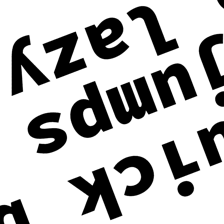

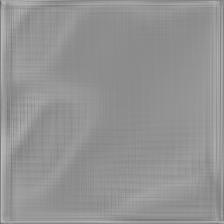

In [59]:
it = iter(data_loader)
for images, unnormalized_images, texts in it:
  x = unnormalized_images.to(device)
  recon_x, mean, logvar = vae(x)
  display(to_pil_image(unnormalized_images[0]))
  display(to_pil_image(recon_x.view(-1, 1, 224, 224)[0].cpu()))
  break